# Employee Retention
__- Author: Fan Yuan__  
__- Date: 03/26/2019__

## Context:
Employee turn-over is a very costly problem for companies. It's important to understand why and when employees are most likely to leave can lead to actions to improve employee retention as well as planning new hiring in advance.

## Project goal:
* Given the information about the employees, predict when employees are going to quit by understanding the main drivers of employee churn  
* Find the main factors that drive employee churn. Explain
* What variable can be added to the data set to help explain the employee churn


___NOTE:
Assume, for each company, that the headcount starts form 0 on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company A and 1000 of them have already quit, then company headcount on 2012/03/02 would be 1000___


## Data:
* The data is from employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general information about the employee, such as average salary during her tenure, dept, and years of experience


### employee_retention -- Columns:
* __employee_id__: id of the employee. Unique by employee per company
* __company_id__: company id
* __dept__: employee dept
* __seniority__: number of years of work experience when hired
* __salary__: average yearly salary of the employee during her tenure within the company
* __join_date__: when the employee joined the company. it can only be between 2011/01/24 and 2015/12/13
* __quit_date__: when the employee left her jon (if she is still employed as of 2015/12/13, this field is NA)


In [18]:
# import libraries needed
library(tidyverse)
library(rpart)
library(scales)

# Set the graph size configuration
options(repr.plot.width = 4, repr.plot.height = 3)

In [2]:
# Read in the data
data <- read.csv('./Data/employee_retention_data.csv')

# Explore the first several rows of data
head(data)

# Check the structure
str(data)

employee_id,company_id,dept,seniority,salary,join_date,quit_date
13021,7,customer_service,28,89000,2014-03-24,2015-10-30
825355,7,marketing,20,183000,2013-04-29,2014-04-04
927315,4,marketing,14,101000,2014-10-13,NA
662910,7,customer_service,20,115000,2012-05-14,2013-06-07
256971,2,data_science,23,276000,2011-10-17,2014-08-22
509529,4,data_science,14,165000,2012-01-30,2013-08-30


'data.frame':	24702 obs. of  7 variables:
 $ employee_id: num  13021 825355 927315 662910 256971 ...
 $ company_id : int  7 7 4 7 2 4 4 2 9 1 ...
 $ dept       : Factor w/ 6 levels "customer_service",..: 1 5 5 1 2 2 1 1 4 6 ...
 $ seniority  : int  28 20 14 20 23 14 21 4 7 7 ...
 $ salary     : num  89000 183000 101000 115000 276000 165000 107000 30000 160000 104000 ...
 $ join_date  : Factor w/ 995 levels "2011-01-24","2011-01-25",..: 643 459 758 264 148 205 558 633 380 280 ...
 $ quit_date  : Factor w/ 664 levels "2011-10-13","2011-10-14",..: 643 364 NA 229 428 267 NA NA 640 NA ...


In [3]:
# Do basic data cleaning
# Convert 'company_id' to categorical variable
data$company_id <- as.factor(data$company_id)

# Convert the date column to date object
data$join_date <- as.Date(data$join_date)
data$quit_date <- as.Date(data$quit_date)

# Dounble check the data
summary(data)

Warning message in strptime(xx, f <- "%Y-%m-%d", tz = "GMT"):
“unknown timezone 'zone/tz/2018i.1.0/zoneinfo/America/New_York'”

  employee_id       company_id                 dept        seniority    
 Min.   :    36   1      :8486   customer_service:9180   Min.   : 1.00  
 1st Qu.:250134   2      :4222   data_science    :3190   1st Qu.: 7.00  
 Median :500793   3      :2749   design          :1380   Median :14.00  
 Mean   :501604   4      :2062   engineer        :4613   Mean   :14.13  
 3rd Qu.:753137   5      :1755   marketing       :3167   3rd Qu.:21.00  
 Max.   :999969   6      :1291   sales           :3172   Max.   :99.00  
                  (Other):4137                                          
     salary         join_date            quit_date         
 Min.   : 17000   Min.   :2011-01-24   Min.   :2011-10-13  
 1st Qu.: 79000   1st Qu.:2012-04-09   1st Qu.:2013-06-28  
 Median :123000   Median :2013-06-24   Median :2014-06-20  
 Mean   :138183   Mean   :2013-06-29   Mean   :2014-05-02  
 3rd Qu.:187000   3rd Qu.:2014-09-17   3rd Qu.:2015-03-27  
 Max.   :408000   Max.   :2015-12-10   Max.   :2015-12-0

In [5]:
# Create new data with 3 columns -- day, employee_headcount, company_id

# Create a list of unique dates for the table
unique_dates <- seq(as.Date("2011/01/24"), as.Date("2015/12/13"), by = "day")

# Create a list of unique companies
unique_companies <- unique(data$company_id)

# Do the cross join to jet all combination of company and dates
data_headcount <- merge(unique_dates, unique_companies, by = NULL)
colnames(data_headcount) <- c("date","company_id")

In [14]:
# Based on each day by company, calculate the headcount (quit/ got hired) on each day
data_join <- data %>%
             group_by(join_date, company_id) %>%
             summarise(join_count = length(join_date))

data_quit <- data %>%
             group_by(quit_date, company_id) %>%
             summarise(quit_count = length(quit_date))

# Combine the join_data, quit_data to prepared date/ company data set
data_headcount <- merge(data_headcount, data_join, 
                        by.x = c("date", "company_id"), 
                        by.y = c("join_date", "company_id"), all.x = TRUE)
data_headcount <- merge(data_headcount, data_quit, 
                        by.x = c("date", "company_id"), 
                        by.y = c("quit_date", "company_id"), all.x = TRUE)

# Replace the NAs with 0
data_headcount$join_count[is.na(data_headcount$join_count)] <- 0
data_headcount$quit_count[is.na(data_headcount$quit_count)] <- 0

In [15]:
# Sum the count by company_id (the data set has been ordered by date)
data_headcount <- data_headcount %>%
                  group_by(company_id) %>%
                  mutate(join_cumsum = cumsum(join_count), 
                         quit_cumsum = cumsum(quit_count))

# For each date, use join_count - quit_count to get the headcount
data_headcount$count <- data_headcount$join_cumsum - data_headcount$quit_cumsum
data_headcount_table <- data.frame(data_headcount[, c("date", "company_id", "count")])

In [17]:
# Do some feture engineering to get better insight on employee retention
# Create the column for employeed length since it's likely to leave the longer the emloyee is in the company
data$employment_length <- as.numeric(data$quit_date - data$join_date)

# Given the date column, get the week of year 
data$week_of_year <- as.numeric(format(data$quit_date,"%U"))

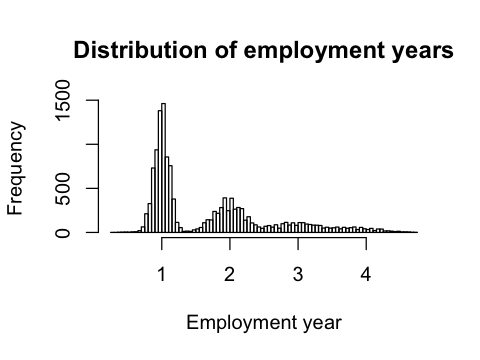

In [22]:
# Plot employee length in years
hist(data$employment_length/365, breaks = 100, xlab = 'Employment year', main = 'Distribution of employment years')

* The graph above shows there are peaks around each employee year anniversary

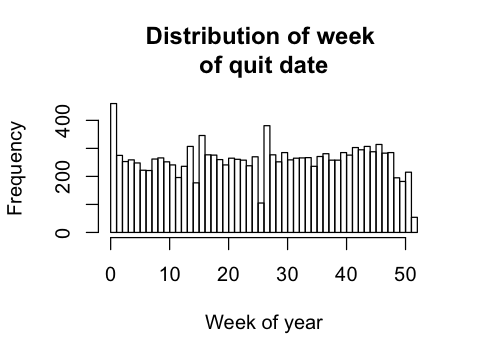

In [24]:
# Plot the week of the year of the quit date
hist(data$week_of_year, breaks = length(unique(data$week_of_year)), xlab = 'Week of year', main = 'Distribution of week 
of quit date')

* The graph shown above also shows there's quit peaks around the new year. Next, we'll try to find if there's any pattern of the people who quiit early. From the graph above, it seems we can separate people into who quit within 1 year and the rest.
* Create two classes of employees:
    + quit within 13 months or not (if they haven't been in the currect company for at least 13 months, remove them)

In [28]:
# Create binary class
# Only keep the people who had enough time of employment (longer than 13 months)
data <- subset(data, data$join_date < as.Date("2015/12/13") - (365 + 31))
# Create the flag column
data$early_quitter <- as.factor(ifelse(is.na(data$quit_date)|as.numeric(data$quit_date - data$join_date) > 396, 0, 1))

In [29]:
# Build the model -- Decision Tree
tree <- rpart(early_quitter ~., data[, c("company_id","dept","seniority","early_quitter","salary")],
             control = rpart.control(minbucket = 30, maxdepth = 3, cp = 0.000001),
             parms = list(prior = c(0.5, 0.5)))
tree

n= 19270 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 19270 9635.0000 0 (0.5000000 0.5000000)  
  2) salary>=224500 2764  855.3351 0 (0.6528040 0.3471960) *
  3) salary< 224500 16506 8026.7840 1 (0.4776014 0.5223986)  
    6) salary< 62500 2887 1249.7210 0 (0.5498859 0.4501141) *
    7) salary>=62500 13619 6500.0510 1 (0.4632968 0.5367032) *

* 'Salary' matters the most. This makes sense. And it also has information about the other variables too.
* From the result, we can see if salary between 62500 and 224500, the employee has higher probabilty of being an early quitter. It means that people who makes a lot of money and very little are not likely to quit

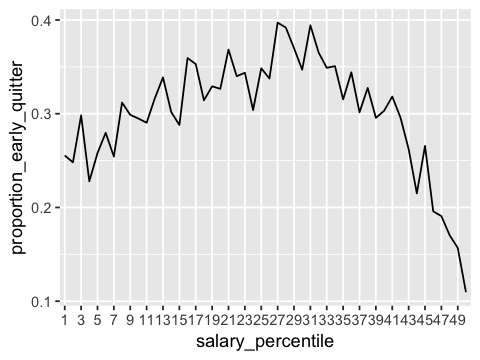

In [33]:
# Plot the proportion of early quitter by salary percentile
data$salary_percentile <- cut(data$salary, breaks = quantile(data$salary, probs = seq(0, 1, 0.02)),
                             include.lowest = TRUE, labels = 1:50)
data_proportion_by_percentile <- data %>% 
                                 group_by(salary_percentile) %>%
                                 summarise(proportion_early_quitter 
                                           = length(early_quitter[early_quitter == 1])/ length(early_quitter))
ggplot(data_proportion_by_percentile, aes(x = salary_percentile, y = proportion_early_quitter)) +
    geom_line(group = 1) +
    scale_x_discrete(breaks = seq(1, 50, by = 2))

## Conclusion
1. Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises reveiced during the employee tenure
2. The major findings are that employees quit at year annicersaries or at the beginning of the year. Both cases make sense. Even if you don't like your current job, you often stay for 1 year before quitting. Also, the beginning of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus
3. Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketbale, so they have a hard time finding a new job